# Analysis focused on understanding the structure of the data, and understanding the format and usefulness of the columns


# 1. Initial Analysis

This section performs an initial exploratory data analysis (EDA) on the preprocessed sleep data. The primary goals are to understand the fundamental structure of the dataset, assess its quality, and get a first look at the relationships between the features and the target variable (`stage`).

---

In [ ]:
import polars as pl
pl.Config.set_fmt_str_lengths(100)

import polars.selectors as cs
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path

In [145]:
file_source = Path().resolve().parents[2] / "datalake" / "processed" / "sleep-cassette" / "subject_id=SC400" / "SC400N1.parquet"

df = pl.read_parquet(file_source)

display(df.head())

subject_id,night_id,tso_min,epoch_idx,t0_sec,stage,EEG_Fpz_Cz_delta_pow_256,EEG_Fpz_Cz_delta_relpow_256,EEG_Fpz_Cz_delta_logpow_256,EEG_Fpz_Cz_delta_peakfreq_256,EEG_Fpz_Cz_theta_pow_256,EEG_Fpz_Cz_theta_relpow_256,EEG_Fpz_Cz_theta_logpow_256,EEG_Fpz_Cz_theta_peakfreq_256,EEG_Fpz_Cz_alpha_pow_256,EEG_Fpz_Cz_alpha_relpow_256,EEG_Fpz_Cz_alpha_logpow_256,EEG_Fpz_Cz_alpha_peakfreq_256,EEG_Fpz_Cz_sigma_pow_256,EEG_Fpz_Cz_sigma_relpow_256,EEG_Fpz_Cz_sigma_logpow_256,EEG_Fpz_Cz_sigma_peakfreq_256,EEG_Fpz_Cz_beta_pow_256,EEG_Fpz_Cz_beta_relpow_256,EEG_Fpz_Cz_beta_logpow_256,EEG_Fpz_Cz_beta_peakfreq_256,EEG_Fpz_Cz_delta_theta_ratio_256,EEG_Fpz_Cz_theta_alpha_ratio_256,EEG_Fpz_Cz_alpha_sigma_ratio_256,EEG_Fpz_Cz_slow_fast_ratio_256,EEG_Fpz_Cz_sef95_256,EEG_Fpz_Cz_medfreq_256,EEG_Fpz_Cz_spec_entropy_256,EEG_Fpz_Cz_aperiodic_slope_256,EEG_Fpz_Cz_delta_pow_512,EEG_Fpz_Cz_delta_relpow_512,EEG_Fpz_Cz_delta_logpow_512,…,Resp_oronasal_zcr_1hz,Resp_oronasal_clip_frac_1hz,Temp_rectal_mean_1hz,Temp_rectal_std_1hz,Temp_rectal_min_1hz,Temp_rectal_max_1hz,Temp_rectal_rms_1hz,Temp_rectal_slope_1hz,Temp_rectal_median_1hz,Temp_rectal_iqr_1hz,Temp_rectal_mad_1hz,Temp_rectal_p01_1hz,Temp_rectal_p10_1hz,Temp_rectal_p90_1hz,Temp_rectal_p99_1hz,Temp_rectal_kurtosis_1hz,Temp_rectal_skewness_1hz,Temp_rectal_diff_rms_1hz,Temp_rectal_zcr_1hz,Temp_rectal_oor_frac_1hz,Event_marker_mean_1hz,Event_marker_std_1hz,Event_marker_min_1hz,Event_marker_max_1hz,Event_marker_rms_1hz,Event_marker_slope_1hz,Event_marker_median_1hz,Event_marker_iqr_1hz,Event_marker_mad_1hz,Event_marker_p01_1hz,Event_marker_p10_1hz,Event_marker_p90_1hz,Event_marker_p99_1hz,Event_marker_kurtosis_1hz,Event_marker_skewness_1hz,Event_marker_diff_rms_1hz,Event_marker_zcr_1hz
str,str,f64,i64,f64,enum,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""SC400""","""N1""",0.0,0,0.0,"""W""",604.421253,0.849005,2.78134,0.78125,88.070385,0.123709,1.94483,4.296875,8.002837,0.011241,0.903244,8.59375,3.140267,0.004411,0.496967,12.5,8.282302,0.011634,0.918151,29.296875,6.862934,11.004896,2.548458,42.52292,5.859375,1.171875,0.54449,-2.28669,734.433847,0.84859,2.865953,…,0.62069,0.033333,37.224695,0.03237,37.174194,37.319355,37.22471,0.000667,37.224194,0.034678,0.017204,37.175129,37.19312,37.251398,37.317796,2.557162,1.261577,0.037636,0.0,0.0,811.966667,263.927703,136.0,947.0,853.78434,-0.413793,914.0,27.0,14.0,136.0,151.4,932.4,945.84,3.33816,-2.254135,204.204428,0.0
"""SC400""","""N1""",0.0,1,30.0,"""W""",365.452854,0.808689,2.562831,0.78125,42.103157,0.093168,1.624315,4.296875,11.523936,0.025501,1.061601,8.59375,8.254673,0.018266,0.9167,14.0625,24.573151,0.054376,1.390461,25.78125,8.679939,3.65354,1.39605,11.290551,16.796875,1.953125,0.648066,-1.397812,319.099341,0.781018,2.503926,…,0.448276,0.0,37.204014,0.020477,37.159142,37.244087,37.20402,-0.001706,37.205376,0.022045,0.010754,37.159142,37.179032,37.230537,37.242839,0.189061,-0.285789,0.02928,0.0,0.0,896.9,22.925023,841.0,940.0,897.192937,-1.551724,895.0,27.0,11.5,844.77,868.6,925.0,939.71,0.217993,-0.182562,26.176457,0.0
"""SC400""","""N1""",0.0,2,60.0,"""W""",474.979507,0.898133,2.676675,0.78125,22.943739,0.043384,1.360664,4.296875,12.804645,0.024212,1.107368,8.984375,4.763458,0.009007,0.677922,12.890625,13.360636,0.025263,1.125827,28.515625,20.701922,1.791829,2.688098,19.029922,8.984375,1.171875,0.483061,-1.472386,548.473319,0.909907,2.739156,…,0.37931,0.0,37.212796,0.017739,37.173119,37.255913,37.2128,-0.00063,37.210217,0.022849,0.012903,37.178108,37.191399,37.233549,37.251547,0.018931,0.178067,0.02872,0.0,0.0,914.366667,23.412936,845.0,955.0,914.666369,2.448276,918.0,27.5,13.5,854.57,888.2,942.4,952.68,1.071721,-0.760668,29.417916,0.0
"""SC400""","""N1""",0.0,3,90.0,"""W""",184.174068,0.822091,2.265228,1.5625,19.000412,0.084811,1.

In [146]:
display(f"Linhas: {df.height}, Colunas: {df.width}")

column_types = pl.Series("Dtypes", df.dtypes)

display(column_types.value_counts())

'Linhas: 2650, Colunas: 250'

Dtypes,count
object,u32
String,2
"Enum(categories=['W', 'N1', 'N2', 'N3', 'REM'])",1
Float64,246
Int64,1


In [147]:
display(df.describe())

statistic,subject_id,night_id,tso_min,epoch_idx,t0_sec,stage,EEG_Fpz_Cz_delta_pow_256,EEG_Fpz_Cz_delta_relpow_256,EEG_Fpz_Cz_delta_logpow_256,EEG_Fpz_Cz_delta_peakfreq_256,EEG_Fpz_Cz_theta_pow_256,EEG_Fpz_Cz_theta_relpow_256,EEG_Fpz_Cz_theta_logpow_256,EEG_Fpz_Cz_theta_peakfreq_256,EEG_Fpz_Cz_alpha_pow_256,EEG_Fpz_Cz_alpha_relpow_256,EEG_Fpz_Cz_alpha_logpow_256,EEG_Fpz_Cz_alpha_peakfreq_256,EEG_Fpz_Cz_sigma_pow_256,EEG_Fpz_Cz_sigma_relpow_256,EEG_Fpz_Cz_sigma_logpow_256,EEG_Fpz_Cz_sigma_peakfreq_256,EEG_Fpz_Cz_beta_pow_256,EEG_Fpz_Cz_beta_relpow_256,EEG_Fpz_Cz_beta_logpow_256,EEG_Fpz_Cz_beta_peakfreq_256,EEG_Fpz_Cz_delta_theta_ratio_256,EEG_Fpz_Cz_theta_alpha_ratio_256,EEG_Fpz_Cz_alpha_sigma_ratio_256,EEG_Fpz_Cz_slow_fast_ratio_256,EEG_Fpz_Cz_sef95_256,EEG_Fpz_Cz_medfreq_256,EEG_Fpz_Cz_spec_entropy_256,EEG_Fpz_Cz_aperiodic_slope_256,EEG_Fpz_Cz_delta_pow_512,EEG_Fpz_Cz_delta_relpow_512,…,Resp_oronasal_zcr_1hz,Resp_oronasal_clip_frac_1hz,Temp_rectal_mean_1hz,Temp_rectal_std_1hz,Temp_rectal_min_1hz,Temp_rectal_max_1hz,Temp_rectal_rms_1hz,Temp_rectal_slope_1hz,Temp_rectal_median_1hz,Temp_rectal_iqr_1hz,Temp_rectal_mad_1hz,Temp_rectal_p01_1hz,Temp_rectal_p10_1hz,Temp_rectal_p90_1hz,Temp_rectal_p99_1hz,Temp_rectal_kurtosis_1hz,Temp_rectal_skewness_1hz,Temp_rectal_diff_rms_1hz,Temp_rectal_zcr_1hz,Temp_rectal_oor_frac_1hz,Event_marker_mean_1hz,Event_marker_std_1hz,Event_marker_min_1hz,Event_marker_max_1hz,Event_marker_rms_1hz,Event_marker_slope_1hz,Event_marker_median_1hz,Event_marker_iqr_1hz,Event_marker_mad_1hz,Event_marker_p01_1hz,Event_marker_p10_1hz,Event_marker_p90_1hz,Event_marker_p99_1hz,Event_marker_kurtosis_1hz,Event_marker_skewness_1hz,Event_marker_diff_rms_1hz,Event_marker_zcr_1hz
str,str,str,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""2650""","""2650""",2650.0,2650.0,2650.0,"""2650""",2650.0,2650.0,2650.0,2650.0,2650.0,2650.0,2650.0,2650.0,2650.0,2650.0,2650.0,2650.0,2650.0,2650.0,2650.0,2650.0,2650.0,2650.0,2650.0,2650.0,2650.0,2650.0,2650.0,2650.0,2650.0,2650.0,2650.0,2650.0,2650.0,2650.0,…,2650.0,2650.0,2650.0,2650.0,2650.0,2650.0,2650.0,2650.0,2650.0,2650.0,2650.0,2650.0,2650.0,2650.0,2650.0,2650.0,2650.0,2650.0,2650.0,2650.0,2650.0,2650.0,2650.0,2650.0,2650.0,2650.0,2650.0,2650.0,2650.0,2650.0,2650.0,2650.0,2650.0,2650.0,2650.0,2650.0,2650.0
"""null_count""","""0""","""0""",0.0,0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,null,250.189811,1324.5,39735.0,null,365.216969,0.834842,2.456656,0.902712,34.698454,0.102468,1.496675,4.654186,7.240728,0.024058,0.831737,8.635171,3.989566,0.011961,0.551416,13.181456,9.641693,0.026671,0.827632,20.46138,10.561184,4.882591,2.106337,27.575923,9.666126,1.674676,0.586377,-2.00304,396.805489,0.839533,…,0.122811,0.003157,36.982217,0.020193,36.940786,37.021086,36.982252,0.000022,36.983483,0.027447,0.012798,36.943263,36.957373,37.006224,37.018945,0.025136,-0.040257,0.025974,0.0,0.0,858.37756,20.057238,815.335094,899.107925,858.645771,0.021431,858.711698,26.192075,13.353396,817.982411,833.633472,882.765509,896.717668,0.005165,-0.064221,24.99418,0.0
"""std""",null,null,270.636411,765.133431,22954.002919,null,237.481117,0.089269,0.343104,0.250547,15.48501,0.061001,0.200166,0.774613,2.637125,0.022993,0.157769,0.738855,1.868738,0.007548,0.217978,1.047146,6.778612,0.016873,0.427475,4.360444,5.818371,1.657479,1.21134,24.259469,3.756854,0.675878,0.072864,0.622058,261.043557,0.090413,…,0.202279,0.03312,0.363874,0.045766,0.386711,0.35102,0.363798,0.004402,0.362796,0.085704,0.022443,0.385863,0.380

## 1.1. Target Variable & Feature Set Composition

We analyze two key structural aspects of the data:

* **Target Distribution (`stage`):** We visualize the distribution of the sleep stages to identify potential **class imbalance**. A heavily skewed distribution is a critical factor that influences model training and the choice of evaluation metrics.
* **Feature Composition:** We group the features by their physiological source (e.g., EEG, EOG, EMG) to understand the overall makeup of our dataset and see which modalities are most heavily represented.

---

/tmp/ipykernel_154588/2776454234.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


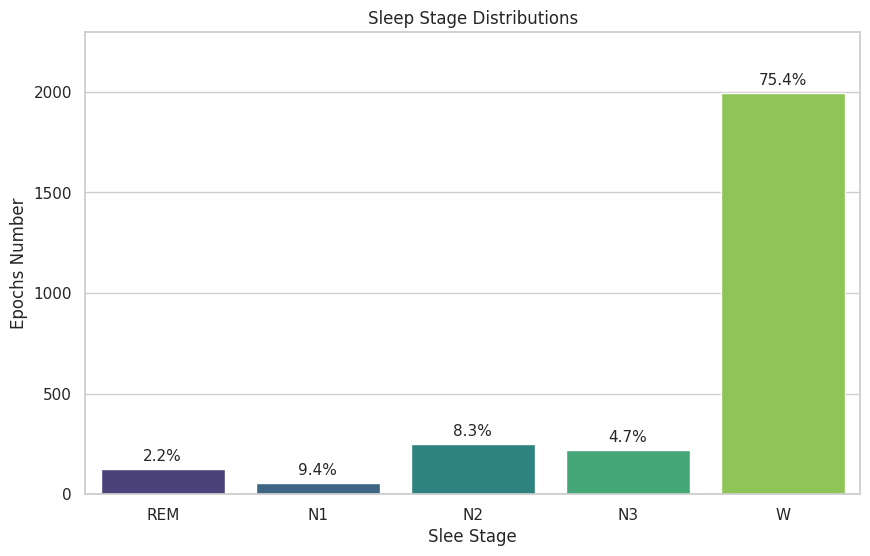

In [148]:
cls_counts = df["stage"].value_counts(sort=True)

cls_counts = cls_counts.with_columns(
    (pl.col("count") / pl.col("count").sum()).alias("proportion")
)

cls_counts = cls_counts.with_columns(
    pl.col("stage").cast(pl.String)
)

stage_order = ["REM", "N1", "N2", "N3", "W"]

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

ax = sns.barplot(
    data=cls_counts, 
    x="stage", 
    y="count",
    order=stage_order,
    palette="viridis"
)

for p, proportion in zip(ax.patches, cls_counts.sort("stage", descending=False).filter(pl.col("stage").is_in(stage_order))['proportion']):
    ax.annotate(f'{proportion:.1%}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points',
                fontsize=11)

ax.set_title("Sleep Stage Distributions")
ax.set_xlabel("Slee Stage", fontsize=12)
ax.set_ylabel("Epochs Number", fontsize=12)
ax.set_ylim(0, cls_counts["count"].max() * 1.15)

plt.show()

/tmp/ipykernel_154588/544919531.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


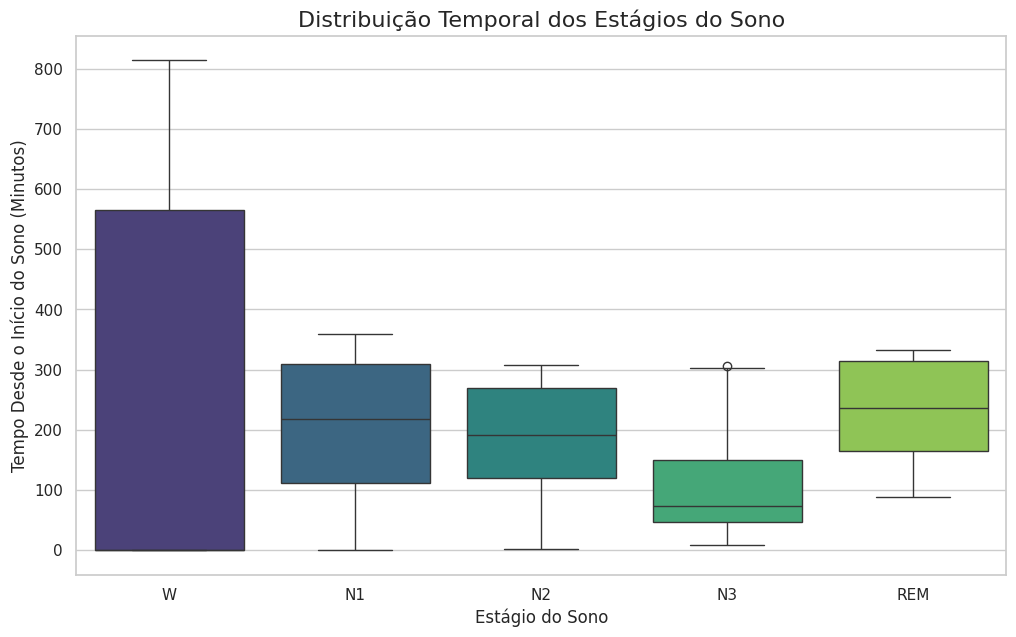

In [ ]:
stage_order = ['W', 'N1', 'N2', 'N3', 'REM']

sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 7))

ax = sns.boxplot(
    data=df.to_pandas(),
    x="stage",
    y="tso_min",
    order=stage_order,
    palette="viridis"
)

ax.set_title('Temporal Distribution of Sleep Stages', fontsize=16)
ax.set_xlabel('Sleep Stages', fontsize=12)
ax.set_ylabel('Time Since Sleep Onset (Minutes)', fontsize=12)

plt.show()

## 1.2. Data Quality & Preliminary Feature Behavior

Next, we conduct a high-level check on data quality and feature behavior:

* **Data Integrity:** We run a quick check to confirm the absence of null values, which simplifies the need for imputation strategies.
* **Feature Behavior Across Stages:** We calculate the mean of a few key EEG spectral features for each sleep stage. This provides an early, high-level indication of which features are likely to be predictive, as we expect their values to differ systematically between stages.

---

In [213]:
display(df.null_count())

subject_id,night_id,tso_min,epoch_idx,t0_sec,stage,EEG_Fpz_Cz_delta_pow_256,EEG_Fpz_Cz_delta_relpow_256,EEG_Fpz_Cz_delta_logpow_256,EEG_Fpz_Cz_delta_peakfreq_256,EEG_Fpz_Cz_theta_pow_256,EEG_Fpz_Cz_theta_relpow_256,EEG_Fpz_Cz_theta_logpow_256,EEG_Fpz_Cz_theta_peakfreq_256,EEG_Fpz_Cz_alpha_pow_256,EEG_Fpz_Cz_alpha_relpow_256,EEG_Fpz_Cz_alpha_logpow_256,EEG_Fpz_Cz_alpha_peakfreq_256,EEG_Fpz_Cz_sigma_pow_256,EEG_Fpz_Cz_sigma_relpow_256,EEG_Fpz_Cz_sigma_logpow_256,EEG_Fpz_Cz_sigma_peakfreq_256,EEG_Fpz_Cz_beta_pow_256,EEG_Fpz_Cz_beta_relpow_256,EEG_Fpz_Cz_beta_logpow_256,EEG_Fpz_Cz_beta_peakfreq_256,EEG_Fpz_Cz_delta_theta_ratio_256,EEG_Fpz_Cz_theta_alpha_ratio_256,EEG_Fpz_Cz_alpha_sigma_ratio_256,EEG_Fpz_Cz_slow_fast_ratio_256,EEG_Fpz_Cz_sef95_256,EEG_Fpz_Cz_medfreq_256,EEG_Fpz_Cz_spec_entropy_256,EEG_Fpz_Cz_aperiodic_slope_256,EEG_Fpz_Cz_delta_pow_512,EEG_Fpz_Cz_delta_relpow_512,EEG_Fpz_Cz_delta_logpow_512,…,Resp_oronasal_zcr_1hz,Resp_oronasal_clip_frac_1hz,Temp_rectal_mean_1hz,Temp_rectal_std_1hz,Temp_rectal_min_1hz,Temp_rectal_max_1hz,Temp_rectal_rms_1hz,Temp_rectal_slope_1hz,Temp_rectal_median_1hz,Temp_rectal_iqr_1hz,Temp_rectal_mad_1hz,Temp_rectal_p01_1hz,Temp_rectal_p10_1hz,Temp_rectal_p90_1hz,Temp_rectal_p99_1hz,Temp_rectal_kurtosis_1hz,Temp_rectal_skewness_1hz,Temp_rectal_diff_rms_1hz,Temp_rectal_zcr_1hz,Temp_rectal_oor_frac_1hz,Event_marker_mean_1hz,Event_marker_std_1hz,Event_marker_min_1hz,Event_marker_max_1hz,Event_marker_rms_1hz,Event_marker_slope_1hz,Event_marker_median_1hz,Event_marker_iqr_1hz,Event_marker_mad_1hz,Event_marker_p01_1hz,Event_marker_p10_1hz,Event_marker_p90_1hz,Event_marker_p99_1hz,Event_marker_kurtosis_1hz,Event_marker_skewness_1hz,Event_marker_diff_rms_1hz,Event_marker_zcr_1hz
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,…,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


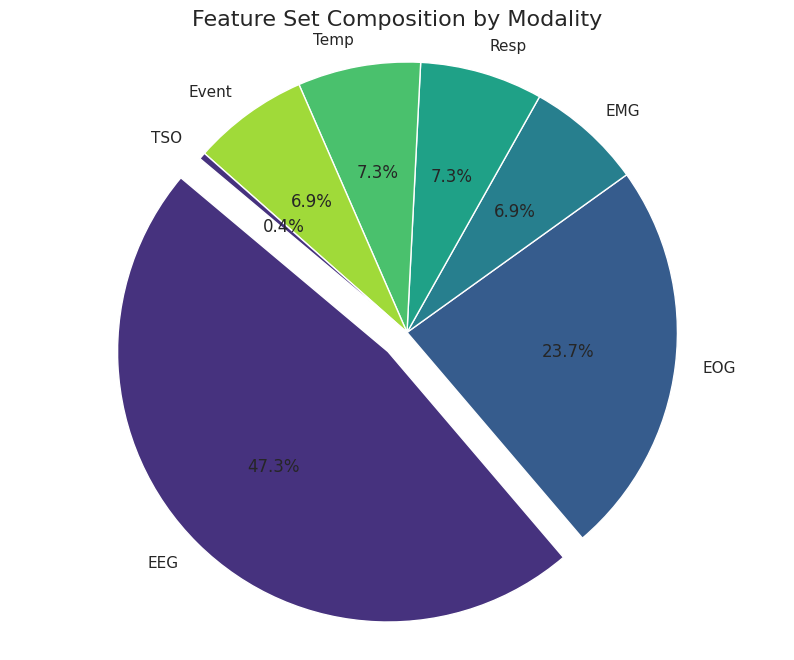

In [158]:
prefix_groups = (
    df.columns
)

groups = {
    "EEG": [c for c in df.columns if c.startswith("EEG")],
    "EOG": [c for c in df.columns if c.startswith("EOG")],
    "EMG": [c for c in df.columns if c.startswith("EMG")],
    "Resp": [c for c in df.columns if c.startswith("Resp")],
    "Temp": [c for c in df.columns if c.startswith("Temp")],
    "Event": [c for c in df.columns if c.startswith("Event")],
    "TSO": ["tso_min"]
}

group_counts = {g: len(cols) for g, cols in groups.items()}

labels = group_counts.keys()
sizes = group_counts.values()

plt.figure(figsize=(10, 8))

explode = [0.1 if label == "EEG" else 0 for label in labels]

plt.pie(sizes, 
        explode=explode, 
        labels=labels, 
        autopct='%1.1f%%', # Formata para mostrar a porcentagem
        shadow=False, 
        startangle=140)

plt.title('Feature Set Composition by Modality', fontsize=16)
plt.axis('equal')
plt.show()

In [ ]:
display(df.group_by("stage").mean().select([
    "stage",
    "EEG_Fpz_Cz_delta_relpow_256",
    "EEG_Fpz_Cz_alpha_relpow_256",
    "EEG_Fpz_Cz_beta_relpow_256",
    "EEG_Fpz_Cz_spec_entropy_256"
]))

stage,EEG_Fpz_Cz_delta_relpow_256,EEG_Fpz_Cz_alpha_relpow_256,EEG_Fpz_Cz_beta_relpow_256,EEG_Fpz_Cz_spec_entropy_256
enum,f64,f64,f64,f64
"""N3""",0.928091,0.010644,0.001963,0.477718
"""W""",0.840918,0.021843,0.031447,0.585287
"""N1""",0.647995,0.07008,0.03629,0.698657
"""REM""",0.665011,0.060846,0.026744,0.704641
"""N2""",0.832512,0.024491,0.007995,0.605527


# 2. Advanced Feature Analysis and Selection Strategy

This section transitions from initial exploration to a deep, quantitative analysis of the feature set. The primary objective is to build a robust foundation for feature selection by systematically evaluating each feature's predictive power and identifying various forms of redundancy.

The analysis is structured around two core principles:
1.  **Quantifying Importance:** Determining how strongly each feature is associated with the sleep stages.
2.  **Identifying Redundancy:** Finding features that are uninformative (constant, duplicate) or carry overlapping information (highly correlated).

---

## 2.1. Feature Importance Ranking with Eta-squared (η²)

The cornerstone of our analysis is the **Eta-squared (η²)** metric. For each numeric feature, we calculate η² with respect to the `stage` target variable.

**What it is:** Eta-squared is a statistical measure that represents the proportion of variance in a continuous feature that can be explained by a categorical variable. In simple terms, it tells us how well the sleep stage categories separate the values of a given feature. A higher η² value indicates a more predictive feature.

The code below calculates η² for all numeric features and displays a ranked list of the most powerful predictors, which will be the primary basis for our selection decisions.

---

## 2.2. Redundancy and Low-Information Analysis

A good feature set is not only predictive but also efficient. This part of the analysis focuses on identifying and understanding different types of redundancy. We will investigate:

* **Low-Information Features:** Columns that are constant, near-constant, or exact duplicates of others. These provide no value to a model and are candidates for immediate removal.
* **Highly Correlated Features:** We will calculate the full correlation matrix to identify pairs of features that carry very similar information. This is explored both globally (by listing the most correlated pairs in the entire dataset) and locally (using heatmaps and network graphs for specific feature families) to build a visual intuition for the relationships between features.

---

## 2.3. Special Investigation: `Event_marker` Features

Finally, we perform a targeted analysis on the `Event_marker` features. While they may show a high association with sleep stages in the η² ranking, the feature documentation warns of a high risk of **data leakage**. This analysis isolates their calculated importance so we can make an informed, final decision about their exclusion from the training set.

In [184]:
constant_cols = [
    c.name for c in df.select(cs.numeric()) 
    if df[c.name].n_unique() <= 1
]

numeric_df = df.select(cs.numeric()).drop(constant_cols)

corr_matrix = numeric_df.corr()

corr_matrix = corr_matrix.with_columns(
    pl.Series("feature_a", numeric_df.columns)
)

top_pairs = (
    corr_matrix.melt(id_vars="feature_a", variable_name="feature_b", value_name="correlation")
    .filter(pl.col("feature_a") != pl.col("feature_b")) 
    .with_columns(
        pl.col("correlation").abs().alias("abs_correlation")
    )
    .sort("abs_correlation", descending=True)
)

print("Top 20 Most Correlated Pairs (Positive or Negative):")
with pl.Config(tbl_rows=-1):
    display(top_pairs.head(100))

Top 20 Most Correlated Pairs (Positive or Negative):


/tmp/ipykernel_154588/1886754732.py:15: DeprecationWarning: `DataFrame.melt` is deprecated; use `DataFrame.unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  corr_matrix.melt(id_vars="feature_a", variable_name="feature_b", value_name="correlation")


feature_a,feature_b,correlation,abs_correlation
str,str,f64,f64
"""t0_sec""","""epoch_idx""",1.0,1.0
"""epoch_idx""","""t0_sec""",1.0,1.0
"""Temp_rectal_rms_1hz""","""Temp_rectal_mean_1hz""",0.999999,0.999999
"""Temp_rectal_mean_1hz""","""Temp_rectal_rms_1hz""",0.999999,0.999999
"""Temp_rectal_p01_1hz""","""Temp_rectal_min_1hz""",0.999943,0.999943
"""Temp_rectal_min_1hz""","""Temp_rectal_p01_1hz""",0.999943,0.999943
"""Temp_rectal_p99_1hz""","""Temp_rectal_max_1hz""",0.999932,0.999932
"""Temp_rectal_max_1hz""","""Temp_rectal_p99_1hz""",0.999932,0.999932
"""EMG_submental_p01_1hz""","""EMG_submental_min_1hz""",0.999687,0.999687


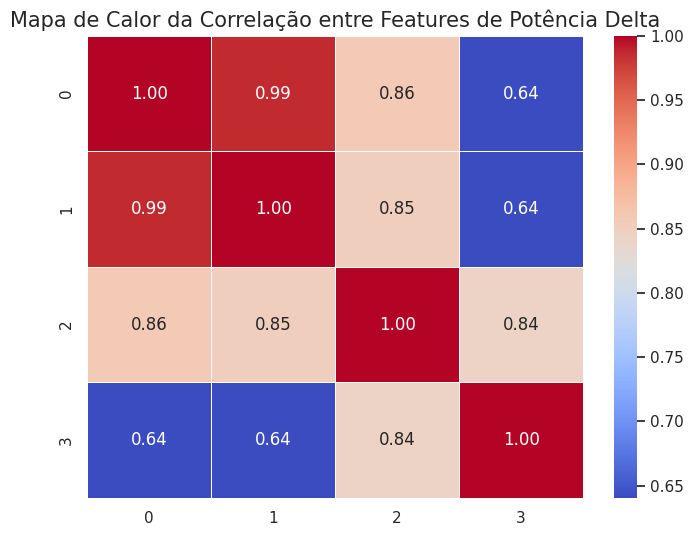

In [159]:
subset = df.select([
    "EEG_Fpz_Cz_delta_pow_256",
    "EEG_Fpz_Cz_delta_pow_512",
    "EEG_Fpz_Cz_delta_logpow_256",
    "EEG_Fpz_Cz_delta_relpow_256"
])

corr_matrix = subset.corr()

plt.figure(figsize=(8, 6))
sns.set_theme(style="white")

sns.heatmap(
    corr_matrix, 
    annot=True,     
    cmap='coolwarm',
    fmt=".2f", 
    linewidths=.5
)

plt.title('Mapa de Calor da Correlação entre Features de Potência Delta', fontsize=15)
plt.show()

In [ ]:
numeric_cols = df.select(cs.numeric().exclude("epoch_idx", "to_sec")).columns

In [186]:
stats_rows = []
for c in numeric_cols:
    s = df.select([
        pl.col(c).std().alias("std"),
        pl.col(c).n_unique().alias("n_unique"),
        pl.col(c).quantile(0.75).alias("q75"),
        pl.col(c).quantile(0.25).alias("q25")
    ]).row(0)
    std, n_unique, q75, q25 = s
    iqr = float(q75 - q25)
    stats_rows.append((c, std, n_unique, iqr))

stats = pl.DataFrame(stats_rows, schema=["feature", "std", "n_unique", "iqr"])

const_feats = stats.filter((pl.col("std").fill_null(0) == 0) | (pl.col("n_unique") == 1))
near_const_feats = stats.filter((pl.col("std") < 1e-6) | (pl.col("iqr") == 0))

with pl.Config(tbl_rows=-1):
    display(const_feats, near_const_feats)

/tmp/ipykernel_154588/2326206455.py:13: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  stats = pl.DataFrame(stats_rows, schema=["feature", "std", "n_unique", "iqr"])


feature,std,n_unique,iqr
str,f64,i64,f64
"""Temp_rectal_zcr_1hz""",0.0,1,0.0
"""Temp_rectal_oor_frac_1hz""",0.0,1,0.0
"""Event_marker_zcr_1hz""",0.0,1,0.0


feature,std,n_unique,iqr
str,f64,i64,f64
"""EEG_Pz_Oz_delta_peakfreq_256""",0.191941,5,0.0
"""EOG_delta_peakfreq_256""",0.086662,4,0.0
"""EOG_medfreq_256""",0.55141,18,0.0
"""EOG_delta_peakfreq_512""",0.165815,7,0.0
"""EMG_submental_zcr_1hz""",0.004539,4,0.0
"""Resp_oronasal_clip_frac_1hz""",0.03312,14,0.0
"""Temp_rectal_zcr_1hz""",0.0,1,0.0
"""Temp_rectal_oor_frac_1hz""",0.0,1,0.0
"""Event_marker_zcr_1hz""",0.0,1,0.0


In [ ]:
hashes_df = df.select([pl.col(c).hash() for c in numeric_cols])

dupe_groups = (
    hashes_df.transpose(include_header=True, header_name="feature")
    .group_by(pl.all().exclude("feature"))
    .agg(pl.col("feature").alias("dupe_cols"))
    .filter(pl.col("dupe_cols").list.len() > 1)
)

dupe_table = dupe_groups.with_row_count("id_group").explode("dupe_cols").rename({"dupe_cols": "duplicated_columns"})

print("Duplicated columns identified table:")
display(dupe_table["duplicated_columns"])

Duplicated columns identified table:


/tmp/ipykernel_154588/1151893584.py:10: DeprecationWarning: `DataFrame.with_row_count` is deprecated; use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  dupe_table = dupe_groups.with_row_count("id_group").explode("dupe_cols").rename({"dupe_cols": "duplicated_columns"})


duplicated_columns
str
"""Temp_rectal_zcr_1hz"""
"""Temp_rectal_oor_frac_1hz"""
"""Event_marker_zcr_1hz"""


In [ ]:
cols = [c for c in df.columns if c.startswith("EEG_Fpz_Cz_delta_") and ("pow" in c or "logpow" in c or "relpow" in c)]
corr_delta = df.select(cols).corr()

hi_pairs = []

names = corr_delta.columns

for i in range(len(names)):
    for j in range(i+1, len(names)):
        r = corr_delta.select(names[i]).row(j)[0]
        if r is not None and abs(r) > 0.80:
            hi_pairs.append((names[i], names[j], float(r)))

hi_pairs_clean = [(str(a), str(b), float(r)) for (a, b, r) in hi_pairs]

stats_df = (
    pl.DataFrame(
        hi_pairs_clean,
        orient="row",
        schema=["feat_a","feat_b","pearson_r"]
    )
    .with_columns(
        pl.col("feat_a").cast(pl.String),
        pl.col("feat_b").cast(pl.String),
        pl.col("pearson_r").cast(pl.Float64)
    )
    .sort("pearson_r", descending=True)
)

with pl.Config(tbl_rows=-1):
    display(stats_df)

feat_a,feat_b,pearson_r
str,str,f64
"""EEG_Fpz_Cz_delta_logpow_256""","""EEG_Fpz_Cz_delta_logpow_512""",0.990323
"""EEG_Fpz_Cz_delta_pow_256""","""EEG_Fpz_Cz_delta_pow_512""",0.986528
"""EEG_Fpz_Cz_delta_relpow_256""","""EEG_Fpz_Cz_delta_relpow_512""",0.985536
"""EEG_Fpz_Cz_delta_pow_256""","""EEG_Fpz_Cz_delta_logpow_256""",0.857739
"""EEG_Fpz_Cz_delta_pow_512""","""EEG_Fpz_Cz_delta_logpow_512""",0.857273
"""EEG_Fpz_Cz_delta_logpow_256""","""EEG_Fpz_Cz_delta_pow_512""",0.850903
"""EEG_Fpz_Cz_delta_relpow_512""","""EEG_Fpz_Cz_delta_logpow_512""",0.845723
"""EEG_Fpz_Cz_delta_pow_256""","""EEG_Fpz_Cz_delta_logpow_512""",0.845716
"""EEG_Fpz_Cz_delta_relpow_256""","""EEG_Fpz_Cz_delta_logpow_256""",0.843166


In [192]:
rows = []
n_total = df.height

glob = df.select([pl.col(c).mean().alias(f"{c}_mean") for c in numeric_cols] +
                 [pl.col(c).var().alias(f"{c}_var") for c in numeric_cols]
                 ).row(0)
glob_means = {c: glob[i] for i, c in enumerate(numeric_cols)}
glob_vars = {c: glob[i+len(numeric_cols)] for i, c in enumerate(numeric_cols)}

gb = df.group_by("stage")
stage_sizes = gb.len().to_dict(as_series=False)
nk_map = dict(zip(stage_sizes["stage"], stage_sizes["len"]))

for c in numeric_cols:
    mu = glob_means[c]
    var_total = glob_vars[c]
    if var_total is None or var_total == 0:
        eta2 = 0.0
    else:
        ss_between_df = gb.agg(
            (pl.len() * (pl.col(c).mean() - mu)**2).alias("ss_between")
        )
        
        ssum = ss_between_df["ss_between"].sum()

        eta2 = ssum / ((n_total - 1) * var_total)

    rows.append((c, eta2))

eta_df = pl.DataFrame(rows, schema={"feature": pl.String, "eta2": pl.Float64}).sort("eta2", descending=True)

with pl.Config(tbl_rows=-1):
    display(eta_df.head(40))

/tmp/ipykernel_154588/1506267078.py:30: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  eta_df = pl.DataFrame(rows, schema={"feature": pl.String, "eta2": pl.Float64}).sort("eta2", descending=True)


feature,eta2
str,f64
"""EEG_Pz_Oz_theta_alpha_ratio_256""",0.80779
"""EEG_Fpz_Cz_aperiodic_slope_256""",0.807708
"""EEG_Fpz_Cz_aperiodic_slope_512""",0.804578
"""EEG_Pz_Oz_theta_alpha_ratio_512""",0.803228
"""Resp_oronasal_zcr_1hz""",0.795862
"""EMG_submental_p01_1hz""",0.793387
"""EMG_submental_p10_1hz""",0.792408
"""EMG_submental_min_1hz""",0.791112
"""EEG_Pz_Oz_aperiodic_slope_256""",0.789177


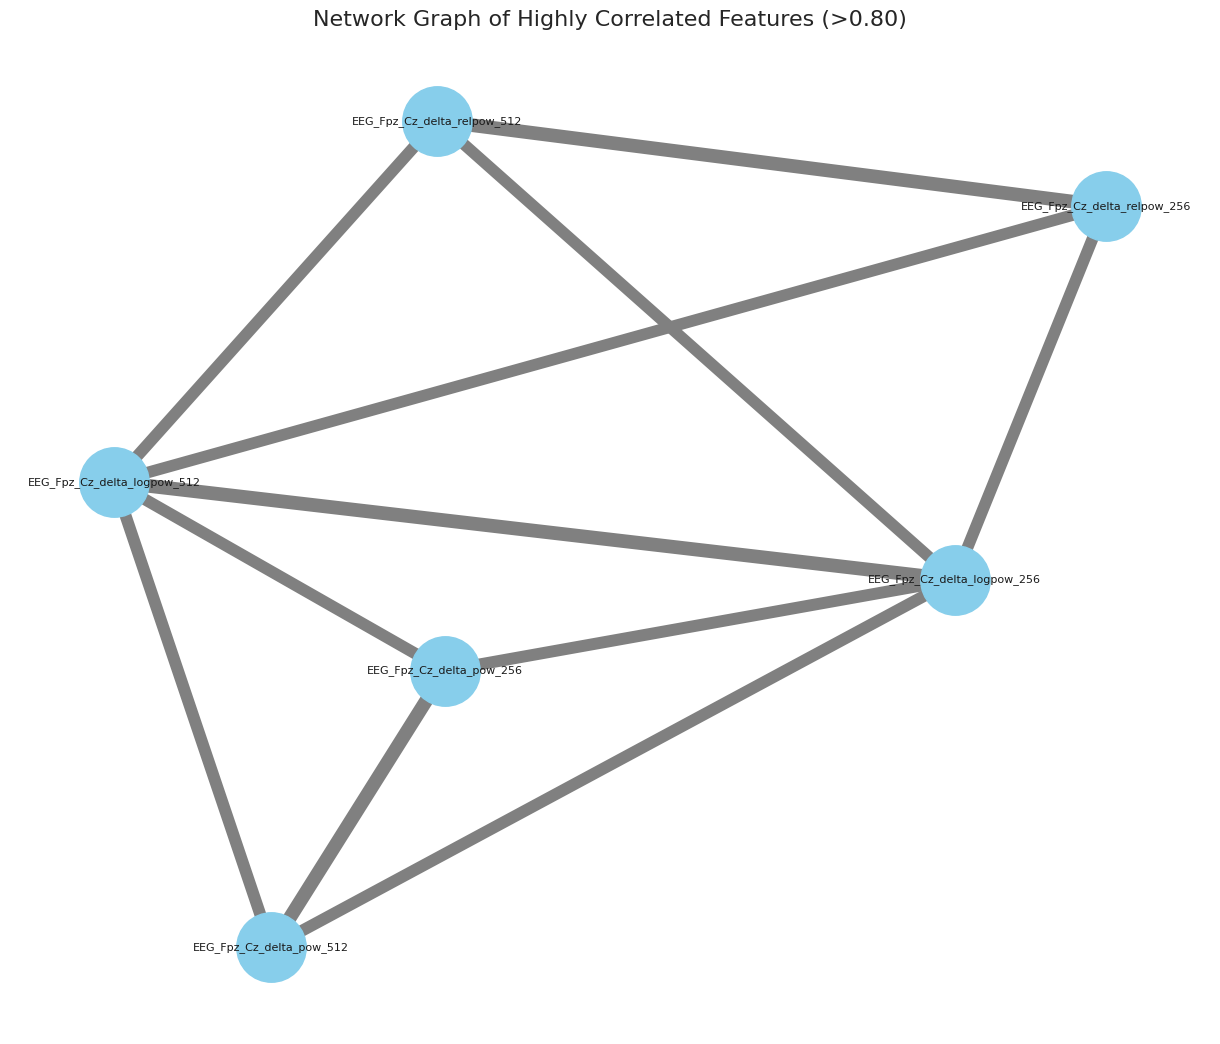

In [190]:
G = nx.Graph()

for feat_a, feat_b, r in hi_pairs_clean:
    G.add_edge(feat_a, feat_b, weight=abs(r))

pos = nx.spring_layout(G, k=1, iterations=30, seed=42)

weights = [G[u][v]['weight'] * 10 for u, v in G.edges()] 

plt.figure(figsize=(12, 10))

nx.draw(G, pos, 
        with_labels=True, 
        node_color='skyblue', 
        node_size=2500, 
        width=weights,
        edge_color='grey',
        font_size=8)

plt.title('Network Graph of Highly Correlated Features (>0.80)', fontsize=16)
plt.show()

In [191]:
evt_cols = [c for c in numeric_cols if c.startswith("Event_marker_")]
eta_evt = eta_df.filter(pl.col("feature").is_in(evt_cols)).sort("eta2", descending=True)

with pl.Config(tbl_rows=-1):
    display(eta_evt)

feature,eta2
str,f64
"""Event_marker_rms_1hz""",0.296634
"""Event_marker_median_1hz""",0.296004
"""Event_marker_mean_1hz""",0.294663
"""Event_marker_p90_1hz""",0.290343
"""Event_marker_p99_1hz""",0.277142
"""Event_marker_max_1hz""",0.270831
"""Event_marker_p10_1hz""",0.232369
"""Event_marker_p01_1hz""",0.160765
"""Event_marker_min_1hz""",0.156554


# 3. Systematic Feature Selection Pipeline

This section consolidates all the previous analyses into a comprehensive, rule-based pipeline. The goal is to move from exploration to action by programmatically generating a final, optimized feature set for the machine learning model.

The strategy is multi-faceted, designed to eliminate uninformative and redundant features while preserving a diverse and powerful set of predictors.

---

## 3.1. Strategy Overview

The pipeline executes a series of sequential filtering and selection steps. The core logic is encapsulated in a final function, `selecionar_features_sono`, which produces the definitive lists of features to keep and remove. The process includes:

1.  **Exploratory Ranking & Visualization:** We first create and visualize ranked lists of the most important features within specific families (e.g., EEG relative power, EOG metrics, EMG candidates). This provides a visual confirmation of which features are most promising.

2.  **Systematic Removal of Problematic Features:** A series of rules are applied to identify and flag features for removal based on the following criteria:
    * **Low-Information:** Constant, near-constant, and duplicate features are dropped.
    * **High Leakage Risk:** All `Event_marker_` features are removed based on domain knowledge.
    * **Spectral Redundancy:** Less predictive power metrics (`pow`, `logpow`) are dropped in favor of the corresponding relative power (`relpow`) feature.
    * **Window-Size Redundancy:** For each feature with `_256` and `_512` variants, only the one with the higher predictive power (η²) is kept.

3.  **Candidate-Based Selection:** For low-rate signals (EMG, Resp, Temp), a hybrid approach is used. A shortlist of interpretable candidate features is created, and from that list, the top performers based on η² are selected.

4.  **Final Consolidation & Review:** All removal rules are aggregated, and a final check for high correlations (`>0.80`) is performed on the remaining set of features. The output is a definitive list of features to keep, a list of all features that were removed, and a detailed table explaining the reason for each removal.

In [ ]:
def plot_feature_importance(df: pl.DataFrame, title: str):
    """Creates a horizontal bar chart for a feature importance DataFrame."""
    plt.figure(figsize=(10, 6))
    sns.set_theme(style="whitegrid")
    
    ax = sns.barplot(
        data=df.to_pandas(),
        y="feature",         
        x="eta2",          
        palette="viridis",
        orient='h'
    )
    
    ax.set_title(title, fontsize=16)
    ax.set_xlabel("Importance (η²)", fontsize=12)
    ax.set_ylabel("Feature", fontsize=12)
    plt.tight_layout()

/tmp/ipykernel_154588/2864240491.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_154588/2864240491.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_154588/2864240491.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


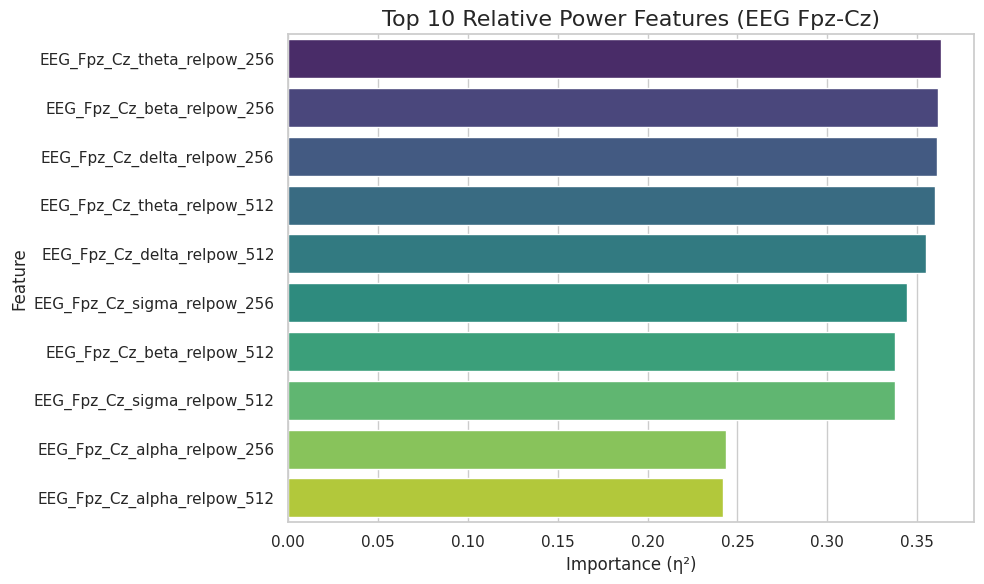

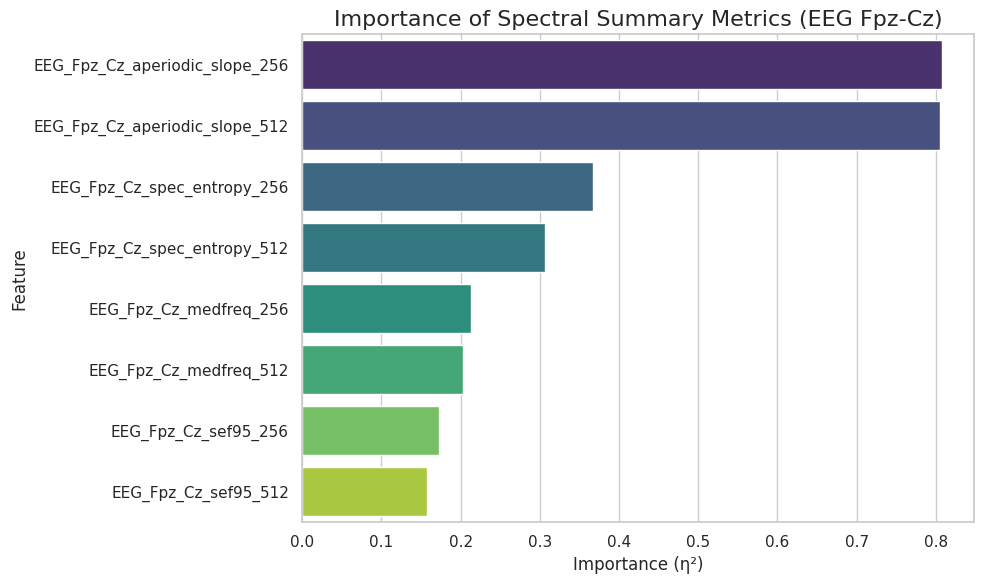

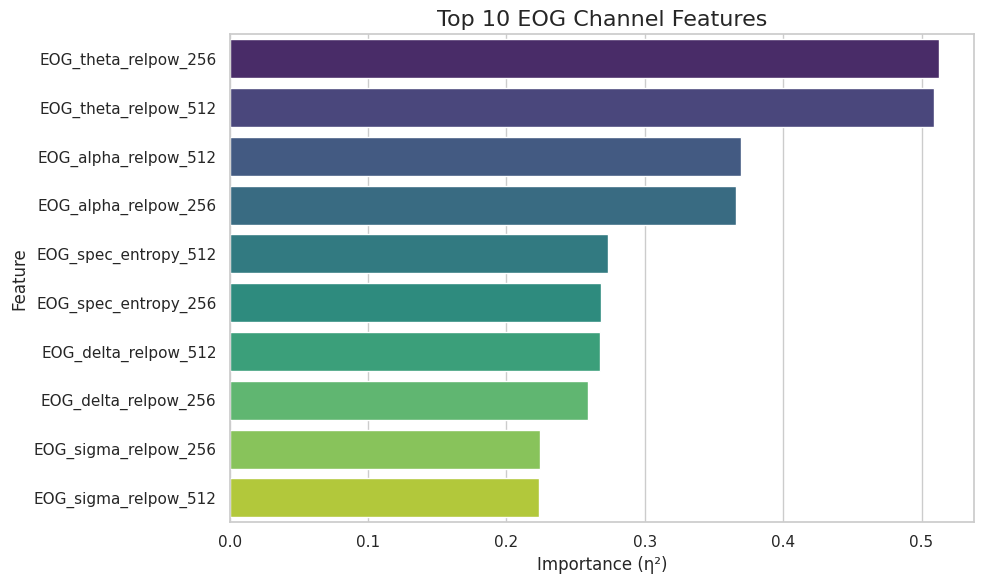

In [ ]:
def top_in_family(prefix, pattern, k=5):
    cols = [c for c in numeric_cols if c.startswith(prefix) and pattern in c]
    return (eta_df.filter(pl.col("feature").is_in(cols))
                    .sort("eta2", descending=True)
                    .head(k)
    )

top_eeg_rel = top_in_family("EEG_Fpz_Cz_", "_relpow_", k=10)
top_eeg_summ = eta_df.filter(pl.col("feature").str.contains("EEG_Fpz_Cz_(sef95|medfreq|spec_entropy|aperiodic_slope)")).sort("eta2", descending=True)
top_eog = eta_df.filter(pl.col("feature").str.contains("^EOG_.*(relpow|spec_entropy)")).sort("eta2", descending=True).head(10) 

plot_feature_importance(top_eeg_rel, 'Top 10 Relative Power Features (EEG Fpz-Cz)')
plot_feature_importance(top_eeg_summ, 'Importance of Spectral Summary Metrics (EEG Fpz-Cz)')
plot_feature_importance(top_eog, 'Top 10 EOG Channel Features')

plt.show()

/tmp/ipykernel_154588/2864240491.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_154588/2864240491.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_154588/2864240491.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


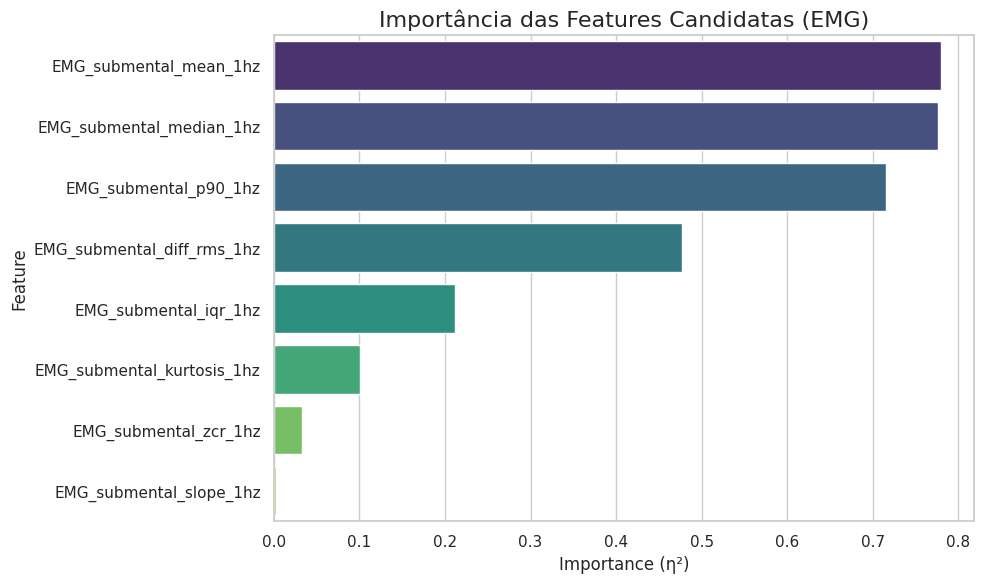

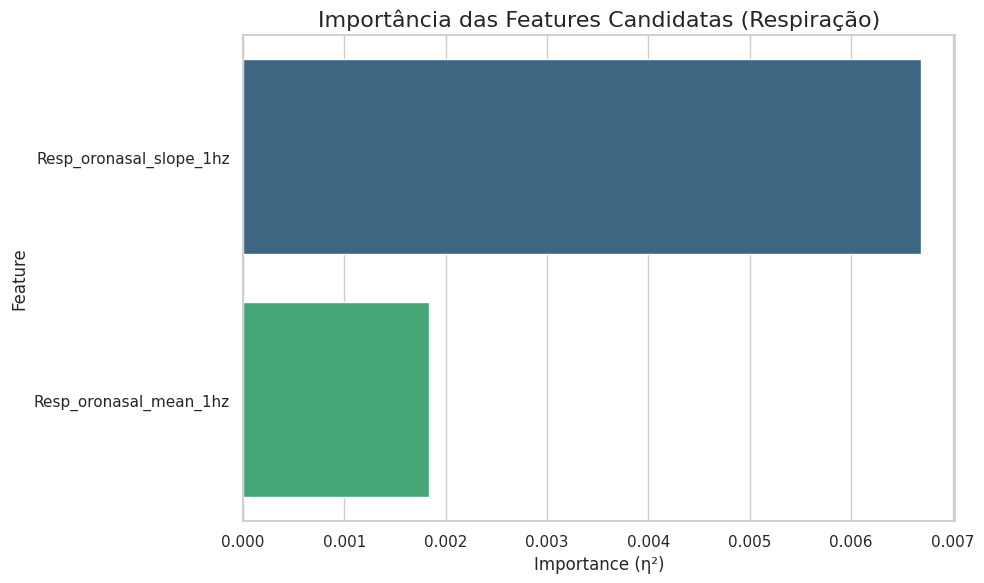

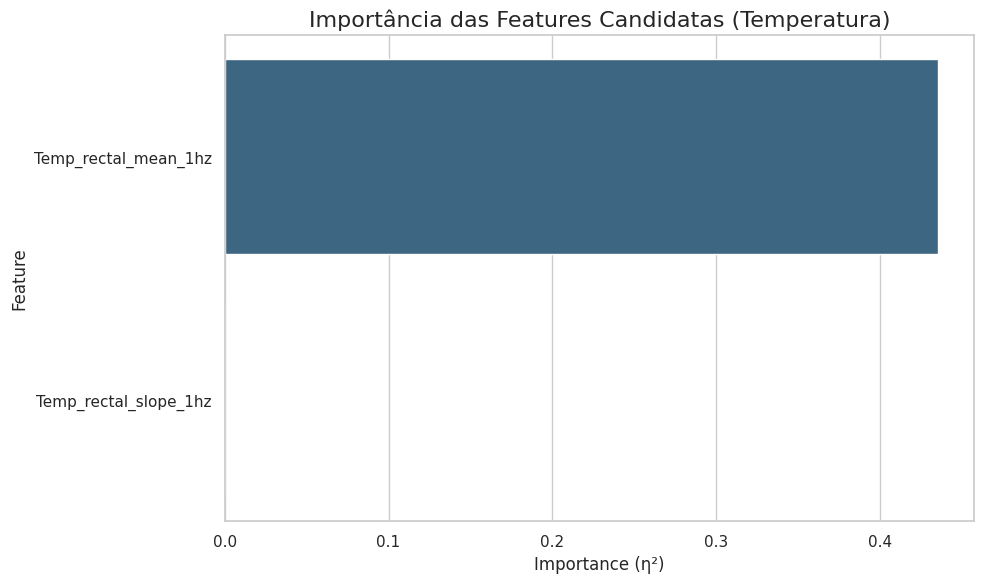

In [198]:
keep_emg_candidates = [c for c in numeric_cols if c.startswith("EMG_submental_")
                       and any(k in c for k in ["median", "p90", "kurtosis", "diff_rms", "zcr", "slope", "mean", "iqr"])]
keep_resp_candidates = [c for c in numeric_cols if c.startswith("Resp_oronasal_")
                        and any(k in c for k in ["mean", "slope"])]
keep_temp_candidates = [c for c in numeric_cols if c.startswith("Temp_rectal_")
                        and any(k in c for k in ["mean", "slope"])]

emg_top = eta_df.filter(pl.col("feature").is_in(keep_emg_candidates)).sort("eta2", descending=True)
resp_top = eta_df.filter(pl.col("feature").is_in(keep_resp_candidates)).sort("eta2", descending=True)
temp_top = eta_df.filter(pl.col("feature").is_in(keep_temp_candidates)).sort("eta2", descending=True)

plot_feature_importance(emg_top, 'Importância das Features Candidatas (EMG)')
plot_feature_importance(resp_top, 'Importância das Features Candidatas (Respiração)')
plot_feature_importance(temp_top, 'Importância das Features Candidatas (Temperatura)')

plt.show()

In [ ]:
drop_event = [c for c in df.columns if c.startswith("Event_marker_")]

drop_const = const_feats["feature"].to_list()
drop_near_const = near_const_feats["feature"].to_list()

def family(band, chan):
    return [f for f in numeric_cols if f.startswith(f"{chan}_{band}_")]

drop_pow_log = []
keep_relpow = []
channels = ["EEG_Fpz_Cz", "EEG_Pz_Oz", "EOG"]
bands = ["delta", "theta", "alpha", "sigma", "beta"]

for chan in channels:
    for band in bands:
        fam = [f for f in numeric_cols if f.startswith(f"{chan}_{band}_")]
        if not fam:
            continue
        eta_fam = eta_df.filter(pl.col("feature").is_in(fam))
        rel = eta_fam.filter(pl.col("feature").str.contains("_relpow_"))

        if rel.height > 0:
            rel_top = rel.sort("eta2", descending=True).row(0)[0]
            keep_relpow.append(rel_top)

            pow_log = eta_fam.filter(pl.col("feature").str.contains("_pow_|_logpow_")).to_dict(as_series=False)
            for f, e in zip(pow_log.get("feature", []), pow_log.get("eta2", [])):
                if e is None or (rel.filter(pl.col("feature")==rel_top).row(0)[1] >=e):
                    drop_pow_log.append(f)

drop_pow_log = list(set(drop_pow_log))

def paired_variants(base_prefix):
    return [c for c in numeric_cols if (c.endswith("_256") or c.endswith("_512")) and c.startswith(base_prefix)]

drop_variants = []

candidates = [c for c in numeric_cols if ("_relpow_" in c) or any(k in c for k in ["sef95", "medfreq", "spec_entropy", "aperiodic_slope"])] 
bases = {}
for c in candidates:
    base = c.replace("_256", "").replace("_512", "")
    bases.setdefault(base, []).append(c)

for base, vars_ in bases.items():
    if len(vars_) == 2:
        e = eta_df.filter(pl.col("feature").is_in(vars_)).sort("eta2", descending=True).to_dict(as_series=False)
        keep = e["feature"][0]
        drop = e["feature"][1]
        drop_variants.append(drop)

temp_all = [c for c in numeric_cols if c.startswith("Temp_rectal_")]
temp_keep = [c for c in temp_all if c.endswith("_mean_1hz") or c.endswith("_slope_1hz")]
temp_maybe_drop = [c for c in temp_all if c not in temp_keep]
eta_temp = eta_df.filter(pl.col("feature").is_in(temp_maybe_drop)).select(pl.col("eta2").mean()).row(0)[0]
drop_temp_rest = temp_maybe_drop if (eta_temp is None or eta_temp < 1e-3) else []

def top_k(prefix, ks):
    feats = [c for c in numeric_cols if c.startswith(prefix)]
    return (eta_df.filter(pl.col("feature").is_in(feats))
            .sort("eta2", descending=True)
            .head(ks)["feature"].to_list())


keep_emg = [c for c in keep_emg_candidates if c in top_k("EMG_submental_", 8)]
keep_resp = [c for c in keep_resp_candidates if c in top_k("Resp_oronasal_", 8)]

drop_all = list(set(drop_event + drop_const + drop_near_const + drop_pow_log + drop_variants + drop_temp_rest))
keep_suggested = list(set(keep_relpow + keep_emg + keep_resp + temp_keep + 
                          [c for c in numeric_cols if ("aperiodic_slope" in c or "spec_entropy" in c or "sef95" in c or "medfreq" in c)] + 
                          ["tso_min"]))

keep_num = [c for c in keep_suggested if c in df.columns]
corr_keep = df.select(keep_num).corr()

high_corr_keep = []
names = corr_keep.columns
for i in range(len(names)):
    for j in range(i+1, len(names)):
        r = corr_keep.select(names[i]).row(j)[0]
        if r is not None and abs(r) > 0.80:
            high_corr_keep.append((names[i], names[j], float(r)))

high_corr_k = pl.DataFrame(high_corr_keep, schema=["feat_a","feat_b","pearson_r"]).sort("pearson_r", descending=True)

drop_all_s = pl.Series("drop_all", drop_all)
keep_suggested_s = pl.Series("keep_suggested", keep_suggested)

with pl.Config(tbl_rows=-1):
    display(drop_all_s, keep_suggested_s, high_corr_k)

/tmp/ipykernel_154588/2698392300.py:85: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  high_corr_k = pl.DataFrame(high_corr_keep, schema=["feat_a","feat_b","pearson_r"]).sort("pearson_r", descending=True)


drop_all
str
"""EOG_delta_peakfreq_256"""
"""EEG_Fpz_Cz_theta_pow_256"""
"""EOG_alpha_pow_256"""
"""EOG_alpha_pow_512"""
"""EEG_Fpz_Cz_theta_logpow_512"""
"""EEG_Pz_Oz_delta_pow_512"""
"""EEG_Fpz_Cz_sigma_pow_256"""
"""EEG_Pz_Oz_sigma_pow_256"""
"""EEG_Fpz_Cz_sef95_512"""


keep_suggested
str
"""EEG_Pz_Oz_theta_relpow_256"""
"""EEG_Pz_Oz_alpha_relpow_256"""
"""EEG_Fpz_Cz_medfreq_512"""
"""EEG_Fpz_Cz_sef95_256"""
"""tso_min"""
"""EEG_Fpz_Cz_spec_entropy_512"""
"""EEG_Pz_Oz_medfreq_512"""
"""Temp_rectal_slope_1hz"""
"""EEG_Pz_Oz_beta_relpow_256"""


feat_a,feat_b,pearson_r
str,str,f64
"""EEG_Pz_Oz_aperiodic_slope_512""","""EEG_Pz_Oz_aperiodic_slope_256""",0.998698
"""EMG_submental_median_1hz""","""EMG_submental_mean_1hz""",0.997858
"""EEG_Pz_Oz_sef95_256""","""EEG_Pz_Oz_sef95_512""",0.997155
"""EEG_Fpz_Cz_aperiodic_slope_512""","""EEG_Fpz_Cz_aperiodic_slope_256""",0.996178
"""EOG_aperiodic_slope_256""","""EOG_aperiodic_slope_512""",0.992073
"""EEG_Pz_Oz_spec_entropy_256""","""EEG_Pz_Oz_spec_entropy_512""",0.986765
"""EOG_sef95_256""","""EOG_sef95_512""",0.97942
"""EMG_submental_p90_1hz""","""EMG_submental_mean_1hz""",0.976263
"""EEG_Pz_Oz_medfreq_512""","""EEG_Pz_Oz_medfreq_256""",0.975965


In [ ]:
def selecionar_features_sono(df: pl.DataFrame, corr_threshold_final: float = 0.85) -> tuple[list, list, pl.DataFrame]:
    """
    Realiza uma seleção de features sistemática em dados de sono, removendo
    automaticamente os marcadores de evento e colunas de identificação/metadados.
    """
    reasons_for_removal = {}
    numeric_cols = df.select(cs.numeric().exclude("epoch_idx", "t0_sec")).columns

    rows = []
    for c in numeric_cols:
        if df[c].dtype in [pl.Date, pl.Datetime, pl.Duration, pl.Time]: continue
        var_total = df.select(pl.col(c).var()).item()
        if var_total is None or var_total == 0: eta2 = 0.0
        else:
            mu = df.select(pl.col(c).mean()).item()
            ss_between_df = df.group_by("stage").agg((pl.len() * (pl.col(c).mean() - mu)**2))
            ss_between = ss_between_df.select(pl.all().exclude("stage").sum()).item()
            eta2 = ss_between / ((df.height - 1) * var_total)
        rows.append((c, eta2))
    eta_df = pl.DataFrame(rows, schema={"feature": pl.String, "eta2": pl.Float64}).sort("eta2", descending=True)

    stats = pl.DataFrame({
        "feature": numeric_cols,
        "std": [df.select(pl.col(c).std()).item() for c in numeric_cols],
        "n_unique": [df.select(pl.col(c).n_unique()).item() for c in numeric_cols]
    })
    const_feats = stats.filter((pl.col("std").fill_null(0) < 1e-6) | (pl.col("n_unique") <= 1))
    for feat in const_feats["feature"]:
        reasons_for_removal[feat] = "Constante ou Quase Constante"

    event_marker_cols = [c for c in numeric_cols if c.startswith("Event_marker_")]
    for feat in event_marker_cols:
        if feat not in reasons_for_removal:
            reasons_for_removal[feat] = "Removido por Regra (Risco de Data Leakage)"

    bases = {c.replace("_256", "").replace("_512", "") for c in numeric_cols if "_256" in c or "_512" in c}
    for base in bases:
        variants = [f for f in [f"{base}_256", f"{base}_512"] if f in numeric_cols]
        if len(variants) == 2:
            eta_vals = eta_df.filter(pl.col("feature").is_in(variants)).sort("eta2", descending=True)
            if eta_vals.height == 2:
                feat_to_drop = eta_vals["feature"][-1]
                if feat_to_drop not in reasons_for_removal:
                    reasons_for_removal[feat_to_drop] = f"Redundante (variante de {eta_vals['feature'][0]})"

    channels = ["EEG_Fpz_Cz", "EEG_Pz_Oz", "EOG"]
    bands = ["delta", "theta", "alpha", "sigma", "beta"]
    for chan in channels:
        for band in bands:
            family_cols = [c for c in numeric_cols if c.startswith(f"{chan}_{band}_")]
            relpow_cols = [c for c in family_cols if "_relpow_" in c]
            pow_log_cols = [c for c in family_cols if "_pow_" in c or "_logpow_" in c]
            if not relpow_cols or not pow_log_cols: continue
            best_relpow_eta = eta_df.filter(pl.col("feature").is_in(relpow_cols))["eta2"].max()
            if best_relpow_eta is None: continue
            for feat in pow_log_cols:
                feat_eta = eta_df.filter(pl.col("feature") == feat)["eta2"].item()
                if feat_eta is not None and feat_eta < best_relpow_eta and feat not in reasons_for_removal:
                    reasons_for_removal[feat] = "Redundante (relpow tem maior eta²)"
    
    features_to_remove_so_far = list(reasons_for_removal.keys())
    features_to_keep_candidates = [c for c in df.columns if c not in features_to_remove_so_far]
    numeric_keepers = [c for c in features_to_keep_candidates if c in numeric_cols]

    corr_matrix = df.select(numeric_keepers).corr()
    for i in range(len(numeric_keepers)):
        feat_a = numeric_keepers[i]
        if feat_a in reasons_for_removal: continue
        for j in range(i + 1, len(numeric_keepers)):
            feat_b = numeric_keepers[j]
            if feat_b in reasons_for_removal: continue
            correlation = corr_matrix.select(pl.col(feat_a)).row(j)[0]
            if correlation is not None and abs(correlation) > corr_threshold_final:
                eta_a = eta_df.filter(pl.col("feature") == feat_a)["eta2"].item()
                eta_b = eta_df.filter(pl.col("feature") == feat_b)["eta2"].item()
                if eta_a is None or eta_b is None: continue
                feat_to_drop = feat_a if eta_a < eta_b else feat_b
                feat_kept = feat_b if eta_a < eta_b else feat_a
                if feat_to_drop not in reasons_for_removal:
                    reasons_for_removal[feat_to_drop] = f"Alta Correlacao com {feat_kept} (r={correlation:.2f}), e menor eta²"

    final_features_to_remove = list(reasons_for_removal.keys())

    _temp_features_to_keep = [c for c in df.columns if c not in final_features_to_remove]
    
    cols_to_exclude_by_name = ['subject_id', 'night_id', 'epoch_idx', 't0_sec']
    final_features_to_keep = [
        col for col in _temp_features_to_keep if col not in cols_to_exclude_by_name
    ]

    reasons_df = pl.DataFrame(list(reasons_for_removal.items()), schema=["feature", "motivo_remocao"]).sort("motivo_remocao")
    
    return final_features_to_keep, final_features_to_remove, reasons_df

df = pl.read_parquet(file_source)

features_a_manter, features_a_remover, motivos_df = selecionar_features_sono(df)

print(f"Total features to KEEP: {len(features_a_manter)}")
print(f"Total features to REMOVE: {len(features_a_remover)}")
print("\n--- List of Features to Keep ---")
print(features_a_manter)
print("\n\n--- Reasons for Removing Features ---")

with pl.Config(tbl_rows=-1, tbl_width_chars=120):
    display(motivos_df)

/tmp/ipykernel_154588/2568004626.py:24: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  eta_df = pl.DataFrame(rows, schema={"feature": pl.String, "eta2": pl.Float64}).sort("eta2", descending=True)


Total features to KEEP: 65
Total features to REMOVE: 181

--- List of Features to Keep ---
['tso_min', 'stage', 'EEG_Fpz_Cz_delta_logpow_256', 'EEG_Fpz_Cz_delta_peakfreq_256', 'EEG_Fpz_Cz_theta_relpow_256', 'EEG_Fpz_Cz_theta_peakfreq_256', 'EEG_Fpz_Cz_alpha_peakfreq_256', 'EEG_Fpz_Cz_sigma_relpow_256', 'EEG_Fpz_Cz_beta_relpow_256', 'EEG_Fpz_Cz_beta_peakfreq_256', 'EEG_Fpz_Cz_delta_theta_ratio_256', 'EEG_Fpz_Cz_aperiodic_slope_256', 'EEG_Fpz_Cz_sigma_peakfreq_512', 'EEG_Fpz_Cz_theta_alpha_ratio_512', 'EEG_Fpz_Cz_alpha_sigma_ratio_512', 'EEG_Pz_Oz_delta_logpow_256', 'EEG_Pz_Oz_delta_peakfreq_256', 'EEG_Pz_Oz_theta_relpow_256', 'EEG_Pz_Oz_theta_peakfreq_256', 'EEG_Pz_Oz_alpha_relpow_256', 'EEG_Pz_Oz_alpha_peakfreq_256', 'EEG_Pz_Oz_delta_theta_ratio_256', 'EEG_Pz_Oz_theta_alpha_ratio_256', 'EEG_Pz_Oz_slow_fast_ratio_256', 'EEG_Pz_Oz_sef95_256', 'EEG_Pz_Oz_theta_logpow_512', 'EEG_Pz_Oz_sigma_peakfreq_512', 'EEG_Pz_Oz_beta_peakfreq_512', 'EEG_Pz_Oz_alpha_sigma_ratio_512', 'EOG_delta_logpow_2

/tmp/ipykernel_154588/2568004626.py:95: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  reasons_df = pl.DataFrame(list(reasons_for_removal.items()), schema=["feature", "motivo_remocao"]).sort("motivo_remocao")


feature,motivo_remocao
str,str
"""EEG_Pz_Oz_aperiodic_slope_256""","""Alta Correlacao com EEG_Fpz_Cz_aperiodic_slope_256 (r=0.85), e menor eta²"""
"""EEG_Fpz_Cz_beta_logpow_256""","""Alta Correlacao com EEG_Fpz_Cz_aperiodic_slope_256 (r=0.89), e menor eta²"""
"""EOG_alpha_logpow_256""","""Alta Correlacao com EEG_Fpz_Cz_beta_logpow_256 (r=0.87), e menor eta²"""
"""EEG_Fpz_Cz_beta_pow_256""","""Alta Correlacao com EEG_Fpz_Cz_beta_logpow_256 (r=0.89), e menor eta²"""
"""EEG_Fpz_Cz_sef95_256""","""Alta Correlacao com EEG_Fpz_Cz_beta_relpow_256 (r=0.91), e menor eta²"""
"""EEG_Fpz_Cz_delta_pow_256""","""Alta Correlacao com EEG_Fpz_Cz_delta_logpow_256 (r=0.86), e menor eta²"""
"""EEG_Fpz_Cz_rms""","""Alta Correlacao com EEG_Fpz_Cz_delta_pow_256 (r=0.88), e menor eta²"""
"""EEG_Fpz_Cz_var""","""Alta Correlacao com EEG_Fpz_Cz_delta_pow_256 (r=0.90), e menor eta²"""
"""EEG_Fpz_Cz_alpha_relpow_256""","""Alta Correlacao com EEG_Fpz_Cz_delta_relpow_256 (r=-0.87), e menor eta²"""
